# **Automatic Denoising of Varince-Covariance Matrices**
Authors: Emiliano Della Vecchia, Federico La Penna, Federico Rossi and Tommaso Zazzaron

# Import Libraries

In [ ]:
import numpy as np, pandas as pd
from datetime import datetime
import yfinance as yf
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#Section 1: Functions


The first snippet of code refers to the functionalities of optimal portfolio optimization.
Specifically, the following optimization problem is performed:

$$
\begin{aligned}
\underset{w \in \mathbb{R}^N}{\mathrm{arg\,min}}\;&\frac{1}{2}\,\mathrm{Var}\bigl[r_\pi\bigr]\\
\text{s.t.}\;&w^\top a = 1
\end{aligned}
$$

The optimization problem refers to the minimum variance problem if $a=\mathbf{1}$ and to the maximum sharpe ratio problem if $a=\mathbf{μ}$. This is performed by optPortNum ($\cdot$). This function takes as input Var-Cov matrix, mu and the short selling contraint (shortSellingConstraints = False/True). In addition to this, getMoments ($\cdot$) and ptf_stats ($\cdot$) functions are implemented, which return, respectively, the moments of the linear returns of a price dataset and the characteristics ($\mu$, var and sharpe-ratio) of a constructed portfolio.


In [ ]:
def getMoments(prices_fct):
  returns_fct = (prices_fct/prices_fct.shift(1))[1:] -1
  mu_fct = returns_fct.mean() * 250
  cov_fct = returns_fct.cov() * 250
  return mu_fct, cov_fct


def ptf_stats(weights_fct, mu_fct, cov_fct, rf_fct):
  ptf_mu_fct = np.dot(weights_fct.T,mu_fct)
  ptf_var_fct = np.dot(np.dot(weights_fct.T,cov_fct),weights_fct)
  ptf_std_fct = np.sqrt(ptf_var_fct)
  ptf_SR_fct = (ptf_mu_fct - rf_fct)/ptf_std_fct
  return ptf_mu_fct, ptf_var_fct, ptf_SR_fct

def objFct(w, cov):
  obj = np.dot(np.dot(w.T,cov),w)
  return obj

def optPortNum(cov, mu = None, flag = 1, shortSellingConstraints = False):

  N = cov.shape[0]

  if flag == 1:
    a = np.ones(shape=(N,1))
  elif flag == 2:
    a = mu

  if shortSellingConstraints == True:
    bnds = tuple( (0,1) for x in range(N))
  else:
    bnds = None

  EWP = np.ones(N)/N

  output = minimize(objFct, EWP, args = cov, bounds = bnds,\
                    constraints = ( {'type': 'eq', 'fun': lambda w: 1-np.dot(w.T,a)}),
                    options={'maxiter': 10000})

  if output['success']:
    wstar = output['x']
  else:
    wstar = None

  return wstar/wstar.sum()


The following code snippet presents the covariance‐matrix denoising functions that will be used:

1. **Spectral Decomposition**  
   Computes the eigenvalues and eigenvectors of the input correlation matrix.

2. **Empirical PDF Estimation**  
   Builds the empirical eigenvalue distribution on a uniform grid.

3. **Marčenko–Pastur PDF**  
   Evaluates the theoretical MP density on the same grid for a given $\sigma^2$.

$$
f(\lambda) =
\begin{cases}
\frac{T}{N} \cdot \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2\pi \lambda \sigma^2} & \text{if } \lambda \in [\lambda_-, \lambda_+] \\
0 & \text{else}
\end{cases}
$$


4. **MSE Loss Function**  
   Measures the mean‐squared error between the empirical and theoretical PDFs, to be minimized in the fit.

5. **Automatic Denoising**  
  Build the denoised correlation matrix   




In [ ]:
def getSpectralDec(A):
  eVal, eVec = np.linalg.eigh(A)
  indices = np.flip(np.argsort(eVal))
  eVal = eVal[indices]
  U = eVec[:,indices]
  lamb = np.diag(eVal)
  return lamb, U

def empirical_lambda(lamb, pts):
  lamb_int= np.linspace(np.min(lamb), np.max(lamb), pts)
  step=(np.max(lamb)-np.min(lamb))/(pts-1)
  epsilon=step/2

  pdf_hat=np.zeros(shape=(pts))
  for i in range(pts):
    pdf_hat[i] = ((np.sum( lamb<= lamb_int[i]+epsilon)/len(lamb)) - (np.sum( lamb<= lamb_int[i]-epsilon)/len(lamb)) )/(2*epsilon)

  return lamb_int, pdf_hat



def MarPasPDF(sigma2, q, x):
    lam_minus = sigma2 * (1 - np.sqrt(1/q))**2
    lam_plus  = sigma2 * (1 + np.sqrt(1/q))**2
    pdf = np.zeros_like(x)
    mp_grid = (x >= lam_minus) & (x <= lam_plus)
    pdf[mp_grid] = q*np.sqrt((lam_plus - x[mp_grid]) * (x[mp_grid] - lam_minus)) / (2*np.pi*sigma2*x[mp_grid])
    return pdf, lam_minus, lam_plus

def loss(sigma2, lambdas, q, pts, bw_method=None):
    grid, pdf_emp = empirical_lambda(lambdas, pts=pts)
    pdf_mp = MarPasPDF(sigma2, q, grid)[0]
    return np.sum((pdf_emp - pdf_mp)**2)



def denoisedMatrix(Delta_matrix, U_matrix, n_goodEig):
  N = Delta_matrix.shape[0]
  denoised_eigenvalues = np.diag(Delta_matrix).copy()
  denoised_eigenvalues[n_goodEig:] = denoised_eigenvalues[n_goodEig:].mean()
  denoised_Delta = np.diag(denoised_eigenvalues)
  denoisedMatrix = U_matrix @ denoised_Delta @ U_matrix.T
  normalization_matrix = np.linalg.inv(np.diag(np.sqrt(np.diag(denoisedMatrix))))
  denoisedMatrix = normalization_matrix @ denoisedMatrix @ normalization_matrix.T
  return denoisedMatrix



#Section 2: Data loading

A dataset of 100 stocks covering a predefined time span has been downloaded in the second section.

In [ ]:
myStart = datetime(2017, 1 ,1)
myEnd = datetime(2021, 12, 31)
websiteTables = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
thirdTable = websiteTables[2]
tickers = thirdTable['Symbol'].values.tolist()
tickers

['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'ADBE',
 'AIG',
 'AMD',
 'AMGN',
 'AMT',
 'AMZN',
 'AVGO',
 'AXP',
 'BA',
 'BAC',
 'BK',
 'BKNG',
 'BLK',
 'BMY',
 'BRK.B',
 'C',
 'CAT',
 'CHTR',
 'CL',
 'CMCSA',
 'COF',
 'COP',
 'COST',
 'CRM',
 'CSCO',
 'CVS',
 'CVX',
 'DE',
 'DHR',
 'DIS',
 'DUK',
 'EMR',
 'FDX',
 'GD',
 'GE',
 'GILD',
 'GM',
 'GOOG',
 'GOOGL',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'INTU',
 'ISRG',
 'JNJ',
 'JPM',
 'KO',
 'LIN',
 'LLY',
 'LMT',
 'LOW',
 'MA',
 'MCD',
 'MDLZ',
 'MDT',
 'MET',
 'META',
 'MMM',
 'MO',
 'MRK',
 'MS',
 'MSFT',
 'NEE',
 'NFLX',
 'NKE',
 'NOW',
 'NVDA',
 'ORCL',
 'PEP',
 'PFE',
 'PG',
 'PLTR',
 'PM',
 'PYPL',
 'QCOM',
 'RTX',
 'SBUX',
 'SCHW',
 'SO',
 'SPG',
 'T',
 'TGT',
 'TMO',
 'TMUS',
 'TSLA',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB',
 'V',
 'VZ',
 'WFC',
 'WMT',
 'XOM']

In [ ]:
prices = pd.DataFrame()

for tick in tickers:
  data = yf.download(tick, start = myStart, end = myEnd, auto_adjust=True)
  if data['Close'].empty:
    print(tick)
  else:
    prices[tick] = data['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

BRK.B


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Here below is shown the time series dataframe of the 100 tickers

In [ ]:
prices

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,26.827244,43.450214,33.456703,101.952766,103.480003,52.686054,11.430000,116.681107,87.030777,37.683498,...,58.273247,142.775818,85.067886,85.239288,37.897747,74.963737,34.990257,44.069458,19.715088,61.824566
2017-01-04,26.797216,44.062878,33.722301,102.197899,104.139999,53.373749,11.430000,118.337708,87.186569,37.859001,...,58.201958,143.182602,85.582382,85.261467,38.177593,75.576683,34.951801,44.108807,19.829943,61.144341
2017-01-05,26.933489,44.397049,34.013603,100.665871,105.910004,53.074398,11.240000,118.422859,86.883194,39.022499,...,57.750534,143.421341,84.744247,85.305962,37.536877,76.463020,35.028721,43.424164,19.873013,60.232849
2017-01-06,27.233755,44.410984,34.938911,101.812698,108.300003,54.053352,11.320000,121.364464,86.309273,39.799500,...,58.724655,143.624786,85.623848,85.476303,37.779903,77.519135,34.509079,43.313984,19.600224,60.198837
2017-01-09,27.483202,44.703381,34.904648,100.674637,108.570000,53.705460,11.490000,122.959137,86.104301,39.846001,...,58.875126,143.217987,84.984932,85.009674,37.610531,77.085381,34.133282,42.684414,19.729443,59.205730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,173.021576,116.595818,130.263702,381.937714,569.619995,52.581829,146.139999,200.121536,251.981079,171.068497,...,169.103149,472.414490,226.560699,182.781387,47.963154,210.975845,42.184666,44.175110,44.326099,53.898926
2021-12-27,176.996719,117.752243,132.416641,393.320648,577.679993,52.888565,154.360001,201.355576,258.327209,169.669495,...,173.109665,476.343475,228.691315,185.296707,48.329414,211.959564,42.184666,44.549633,44.729675,54.667400
2021-12-28,175.975906,117.734734,131.489929,393.263855,569.359985,52.674774,153.149994,201.892151,260.795074,170.660995,...,172.441925,479.624023,229.871933,184.926270,48.337933,212.368591,42.216690,44.229923,45.371582,54.490734


In [ ]:
returns = (prices/prices.shift(1))[1:] -1
data = yf.download('^IRX', start = myStart, end = myEnd, auto_adjust=True)
rf_series = data['Close']/100
rf = rf_series.mean().iloc[0]

[*********************100%***********************]  1 of 1 completed


# Section 3: In-Sample and Out-Of-Sample splitting, Covariance-Correlation Bridge and Distribution Fitting


## In-Sample and Out-Of-Sample splitting

Here, a return series spanning the entire study period is first divided into an in-sample (training) segment and an out-of-sample (testing) segment. On each of these segments, the getMoments routine is used to compute the first two statistical moments: the vector of expected returns and the covariance matrix of asset returns. These moment estimates form the basis for all subsequent portfolio constructions.

Once the in-sample estimates are available, the ptf_stats function is applied to the out-of-sample returns to assess three distinct allocation portfolios: an Equally Weighted Portfolio (EWP), a Minimum-Variance Portfolio (Min-Var), and a Maximum-Sharpe Ratio Portfolio (Max-Sharpe). Ptf_stats calculates realized return, volatility, and the Sharpe ratio under each portfolio, thereby providing a comparison of out-of-sample performance.

In [ ]:
prices_training = prices['2018-1-1':'2021-6-30']
prices_test = prices['2021-7-1':'2021-12-31']
rf_series_training = rf_series['2018-1-1':'2021-6-30']
rf_series_test = rf_series['2021-7-1':'2021-12-31']

mu_training, cov_training = getMoments(prices_training)
mu_test, cov_test = getMoments(prices_test)
rf_training = rf_series_training.mean().iloc[0]
rf_test = rf_series_test.mean().iloc[0]

N = cov_training.shape[0]
w_naive = np.ones(N)/N # equally weighted allocation

w_minVar_training = optPortNum(cov_training)
w_MaxSharpe_training = optPortNum(cov_training, mu_training, 2, False)

#Out-of-Sample test
w_naive_statsOOS1 = ptf_stats(w_naive, mu_test, cov_test, rf_test)
w_minVar_statsOOS1 = ptf_stats(w_minVar_training, mu_test, cov_test, rf_test)
w_MaxSharpe_statsOSS1 = ptf_stats(w_MaxSharpe_training, mu_test, cov_test, rf_test)
w_MaxSharpe_statsOSS1

stats_OOS1 = pd.DataFrame([w_naive_statsOOS1, w_minVar_statsOOS1, w_MaxSharpe_statsOSS1, w_minVar_statsOOS1, w_MaxSharpe_statsOSS1],\
                    columns = ['Exp Return', 'Var', 'SR'],
                    index = ['Naive','Min Var','Max Sharpe', 'Min Var - denoised', 'Max Sharpe - denoised'])

## Covariance-Correlation matrix bridge
The cov2corr function first extracts the variances on the diagonal of the covariance matrix and takes their square roots to obtain the vector of standard deviations. It then forms the outer product of this vector with itself to build the matrix of pairwise σᵢσⱼ products. Finally, each covariance entry is divided by the corresponding σᵢσⱼ, yielding a symmetric correlation matrix with ones on the diagonal.
Following:
$$
\rho=\frac{\sigma_{i,j}}{\sigma_i \sigma_j}
$$
\
Corr2cov routine transforms a correlation matrix into a covariance matrix by using the variances of each individual series. It takes the standard deviations and then constructs a matrix by the outer product of these standard deviations.

$$
\sigma\,\sigma^\top
=
\begin{pmatrix}
\sigma_1^2           & \sigma_1\,\sigma_2 & \dots  & \sigma_1\,\sigma_N \\[6pt]
\sigma_2\,\sigma_1   & \sigma_2^2         & \dots  & \sigma_2\,\sigma_N \\[6pt]
\vdots               & \vdots             & \ddots & \vdots             \\[6pt]
\sigma_N\,\sigma_1   & \sigma_N\,\sigma_2 & \dots  & \sigma_N^2
\end{pmatrix}
$$
 Finally, it performs an element-wise multiplication of this matrix with the correlation matrix, C, yielding the covariance matrix.

In [ ]:
def cov2corr(cov):
  stds = np.sqrt(np.diag(cov))
  corr = cov/np.outer(stds,stds)
  return corr

def corr2cov(corr, stds):
  return corr*np.outer(stds,stds)

In [ ]:
corr_training = cov2corr(cov_training)
corr_training

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
AAPL,1.000000,0.397291,0.551912,0.621667,0.695119,0.371651,0.523644,0.499578,0.438519,0.656630,...,0.650525,0.504289,0.522208,0.483588,0.395431,0.649755,0.304836,0.391847,0.404627,0.384405
ABBV,0.397291,1.000000,0.491687,0.489777,0.428623,0.375518,0.311307,0.506088,0.358115,0.317340,...,0.422731,0.490381,0.403174,0.362079,0.385395,0.486134,0.387389,0.368422,0.291084,0.370547
ABT,0.551912,0.491687,1.000000,0.619749,0.561982,0.346240,0.416865,0.592654,0.529092,0.463603,...,0.554921,0.590083,0.460061,0.451629,0.404506,0.598193,0.429685,0.381562,0.426658,0.338404
ACN,0.621667,0.489777,0.619749,1.000000,0.662314,0.575995,0.420405,0.530720,0.563966,0.514677,...,0.651462,0.564162,0.645256,0.503538,0.621953,0.778881,0.459269,0.576183,0.406073,0.524476
ADBE,0.695119,0.428623,0.561982,0.662314,1.000000,0.328205,0.535625,0.519153,0.462538,0.725961,...,0.652441,0.492660,0.481111,0.458827,0.341052,0.693845,0.272208,0.334431,0.398536,0.295596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.649755,0.486134,0.598193,0.778881,0.693845,0.583749,0.477593,0.513647,0.522913,0.535556,...,0.651908,0.608199,0.657183,0.472927,0.608530,1.000000,0.401223,0.569033,0.367712,0.575387
VZ,0.304836,0.387389,0.429685,0.459269,0.272208,0.372744,0.217566,0.436094,0.457876,0.206031,...,0.378667,0.450892,0.390835,0.359924,0.474917,0.401223,1.000000,0.433387,0.460613,0.384254
WFC,0.391847,0.368422,0.381562,0.576183,0.334431,0.716630,0.254185,0.394330,0.380499,0.237728,...,0.491325,0.482382,0.584681,0.436149,0.861495,0.569033,0.433387,1.000000,0.308237,0.682004
WMT,0.404627,0.291084,0.426658,0.406073,0.398536,0.193876,0.273610,0.450674,0.406570,0.349590,...,0.413255,0.372211,0.311669,0.391024,0.297921,0.367712,0.460613,0.308237,1.000000,0.255732


In [ ]:
np.linalg.det(cov_training)

np.float64(2.4737051211296615e-147)

In [ ]:
Lambda_training, U_training = getSpectralDec(corr_training)
Lambda_training

array([[4.76497164e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.19631401e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.81242220e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.56296273e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.49814981e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.69147457e-03]])

In [ ]:
autovalori= np.diag(Lambda_training)
autovalori

array([4.76497164e+01, 7.19631401e+00, 4.81242220e+00, 2.26915637e+00,
       1.79653042e+00, 1.45734825e+00, 1.39196039e+00, 1.29601308e+00,
       1.11566209e+00, 9.97091834e-01, 9.22488289e-01, 8.83488729e-01,
       8.59494095e-01, 8.24898317e-01, 8.21535955e-01, 7.59423931e-01,
       7.39497833e-01, 7.15791626e-01, 6.80231875e-01, 6.62675268e-01,
       6.48069176e-01, 6.31500218e-01, 6.15934506e-01, 5.98426207e-01,
       5.75991200e-01, 5.71415589e-01, 5.54820330e-01, 5.23764390e-01,
       5.14157468e-01, 4.91618986e-01, 4.87456433e-01, 4.73124197e-01,
       4.68998276e-01, 4.57477025e-01, 4.46846137e-01, 4.39940583e-01,
       4.22554411e-01, 4.12694871e-01, 4.07385178e-01, 3.96437260e-01,
       3.86378738e-01, 3.71148776e-01, 3.58032152e-01, 3.50491894e-01,
       3.47874650e-01, 3.44395830e-01, 3.26846191e-01, 3.21319872e-01,
       3.14310074e-01, 3.11716502e-01, 3.01093480e-01, 2.96071876e-01,
       2.91896986e-01, 2.84906443e-01, 2.77454930e-01, 2.71969736e-01,
      

##Fitting Distributions
This section concludes by fitting the empirical eigenvalue distribution to the Marčenko–Pastur law. In keeping with the literature, this fit determines the optimal value of
$\sigma^2$ and thereby computes the upper edge $\lambda^+$
, which serves as the cutoff separating noise‐dominated eigenvalues from informative ones.
\
The computation is performed by minimizing the MSE loss between the theoretical Marčenko–Pastur distribution and the empirical eigenvalue distribution.










In [ ]:
eigenvalues= np.diag(Lambda_training)
T = prices_training.shape[0]
N = prices_training.shape[1]
q= T/N
pts= 200

print(eigenvalues.shape)
print(N)
print(T)

ig= 0.3
bnds = [(0, None)]
sigma2 = minimize(loss, ig, args=(eigenvalues, q, pts), method='Nelder-Mead', bounds=bnds)
sigma2 = sigma2.x
sigma2

(100,)
100
880


array([0.44648438])

The minimization output indicates an optimal $\sigma^2$ of 0.44648438.

## Plots

Here the theoretical MP PDF vs the Empirical PDF via KDE has been plotted. The optimization process worked since the result of the fitting is quite accurate

Lambda minus: [0.19620153]
Lambda plus [0.79824094]


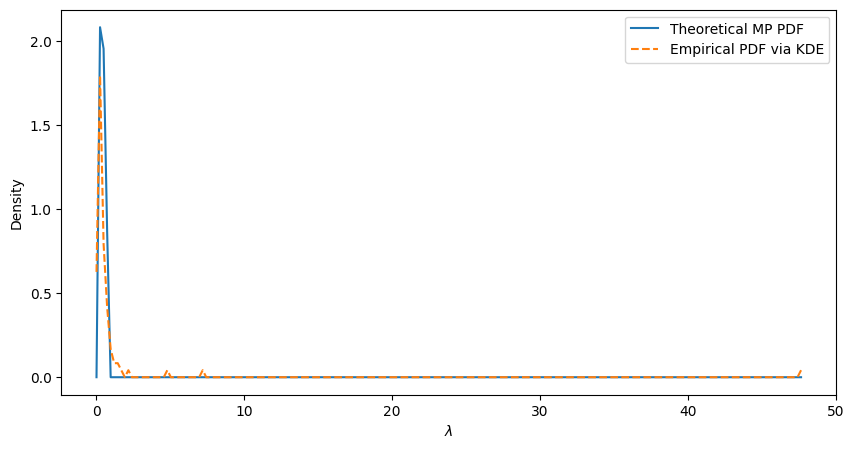

In [ ]:
emp_lamb, emp_pdf = empirical_lambda(eigenvalues, pts=200)

pdf_mp, a, b = MarPasPDF(sigma2, q, emp_lamb)

print('Lambda minus:', a)
print('Lambda plus', b)


MP_lamb = emp_lamb
MP_PDF_training = pdf_mp

# plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(MP_lamb, MP_PDF_training, label='Theoretical MP PDF')
ax.plot(emp_lamb, emp_pdf, '--', label='Empirical PDF via KDE')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Density')
ax.legend()
plt.show()


Here below, the Empirical Histogram of the eigenvalues vs the theoretical MP PDF has been plotted

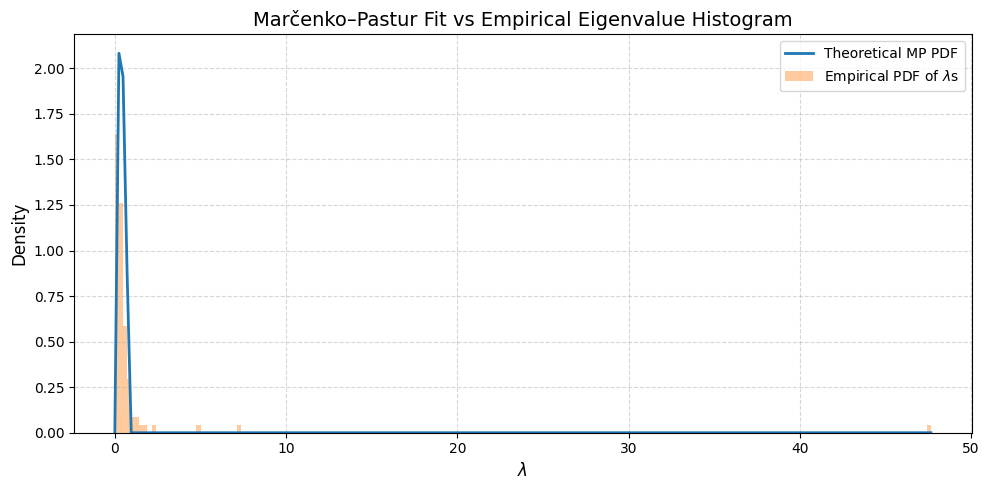

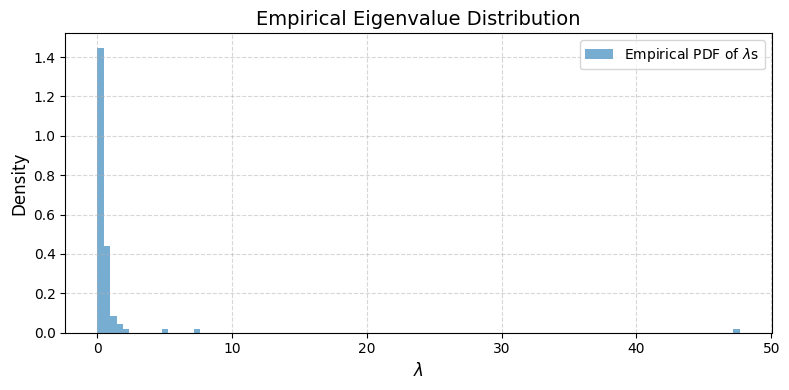

In [ ]:
eigvals = np.diag(Lambda_training)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(MP_lamb, MP_PDF_training,lw=2, label='Theoretical MP PDF')

ax.hist(eigvals, bins=200, density=True, alpha=0.4, label=r'Empirical PDF of $\lambda$s')

ax.set_xlabel(r'$\lambda$', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Marčenko–Pastur Fit vs Empirical Eigenvalue Histogram', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 4))

ax2.hist(eigvals, bins=100, density=True, alpha=0.6, label=r'Empirical PDF of $\lambda$s')

ax2.set_xlabel(r'$\lambda$', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Empirical Eigenvalue Distribution', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Get Eigenvalues

The eigenvalues have been classified into noisy and informative components based on the threshold:
$$
\lambda_{+} = \sigma^2 \left( 1 + \sqrt{ \dfrac{N}{T} } \right)^2
$$

as derived from the Marchenko–Pastur distribution.


In [ ]:
n_goodEig = np.sum( np.diag(Lambda_training) > b)
n_goodEig

np.int64(15)

In [ ]:
n_badeig = np.sum( (np.diag(Lambda_training) <= b))
n_badeig

np.int64(85)

# Section 4: Var/Cov Matrix Denoising

## Correlation Matrix Denoising

The goal is to construct a denoised correlation matrix $C_1$ that is numerically stable and well-conditioned, avoiding extremely small eigenvalues in the correlation (and consequently in the covariance) matrix, which may lead to instability in portfolio optimization and matrix inversion.

The spectral decomposition of the empirical correlation matrix $C$ is:

$$
C = U \, \Delta \, U^\top
$$

where $U$ is the matrix of orthonormal eigenvectors and $\Delta$ is the diagonal matrix containing the eigenvalues $\lambda_1, \ldots, \lambda_N$.

Once the number $k$ of informative eigenvalues is identified (i.e., those such that $\lambda_i > \lambda_+$, with $\lambda_+$ being the upper edge of the Marchenko–Pastur distribution), a modified diagonal matrix $\widetilde{\Delta}$ has been constructed by replacing all eigenvalues below $\lambda_+$ with their average:

$$
\widetilde{\lambda}_i =
\begin{cases}
\lambda_i & \text{if } i \leq k \\\\
\displaystyle \frac{1}{N - k} \sum_{j = k+1}^{N} \lambda_j & \text{if } i > k
\end{cases}
$$

The intermediate matrix $\widetilde{C}$ is defined as:

$$
\widetilde{C} = U \, \widetilde{\Delta} \, U^\top
$$

However, $\widetilde{C}$ is not guaranteed to have unit diagonal entries, and therefore it is not yet a proper correlation matrix. To restore unit diagonal normalization, it is useful to apply a final renormalization step:

$$
C_1 = D^{-1/2} \, \widetilde{C} \, D^{-1/2}
$$

where $D = \operatorname{diag}(\widetilde{C})$ is the diagonal matrix containing the diagonal elements of $\widetilde{C}$. The resulting matrix $C_1$ is the denoised correlation matrix: it is symmetric, positive semi-definite, and has unit diagonal.

In [ ]:
def denoisedMatrix(Delta_matrix, U_matrix, n_goodEig):
  denoised_eigenvalues = np.diag(Delta_matrix).copy()
  denoised_eigenvalues[n_goodEig:] = denoised_eigenvalues[n_goodEig:].mean()
  denoised_Delta = np.diag(denoised_eigenvalues)
  denoisedMatrix = U_matrix @ denoised_Delta @ U_matrix.T
  normalization_matrix = np.linalg.inv(np.diag(np.sqrt(np.diag(denoisedMatrix))))
  denoisedMatrix = normalization_matrix @ denoisedMatrix @ normalization_matrix.T
  return denoisedMatrix

In [ ]:
C1= denoisedMatrix(Lambda_training, U_training, n_goodEig)
pd.DataFrame(C1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.442212,0.560703,0.616841,0.675308,0.364524,0.590095,0.512775,0.465512,0.630517,...,0.639295,0.511594,0.514638,0.518290,0.368767,0.609284,0.333733,0.378499,0.422939,0.374860
1,0.442212,1.000000,0.541481,0.507077,0.438332,0.379721,0.381280,0.602505,0.390939,0.367553,...,0.471034,0.578689,0.455232,0.388426,0.385936,0.485368,0.429855,0.388876,0.321864,0.409033
2,0.560703,0.541481,1.000000,0.617892,0.548980,0.325761,0.449173,0.622585,0.554626,0.455198,...,0.557012,0.573777,0.490381,0.480373,0.387300,0.578612,0.451728,0.373421,0.432388,0.316658
3,0.616841,0.507077,0.617892,1.000000,0.603180,0.534432,0.474577,0.554211,0.542030,0.506653,...,0.608887,0.603928,0.627989,0.502334,0.548169,0.700328,0.464627,0.536567,0.439726,0.492175
4,0.675308,0.438332,0.548980,0.603180,1.000000,0.305002,0.588421,0.500159,0.436732,0.689827,...,0.597244,0.484862,0.442577,0.442050,0.291497,0.611404,0.286970,0.301710,0.397149,0.277208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.609284,0.485368,0.578612,0.700328,0.611404,0.550265,0.484723,0.495983,0.494820,0.513664,...,0.595035,0.590665,0.622746,0.450105,0.534739,1.000000,0.389148,0.524134,0.355506,0.518236
96,0.333733,0.429855,0.451728,0.464627,0.286970,0.382433,0.219080,0.519458,0.519056,0.208127,...,0.390183,0.479226,0.396034,0.409489,0.458308,0.389148,1.000000,0.450416,0.526952,0.380686
97,0.378499,0.388876,0.373421,0.536567,0.301710,0.670841,0.264087,0.392334,0.373154,0.222043,...,0.444497,0.485157,0.565552,0.431105,0.724863,0.524134,0.450416,1.000000,0.307762,0.601054
98,0.422939,0.321864,0.432388,0.439726,0.397149,0.200932,0.342414,0.476682,0.459195,0.362611,...,0.424162,0.378224,0.326129,0.447023,0.294711,0.355506,0.526952,0.307762,1.000000,0.268254


## Denoised correlation matrix heatmap

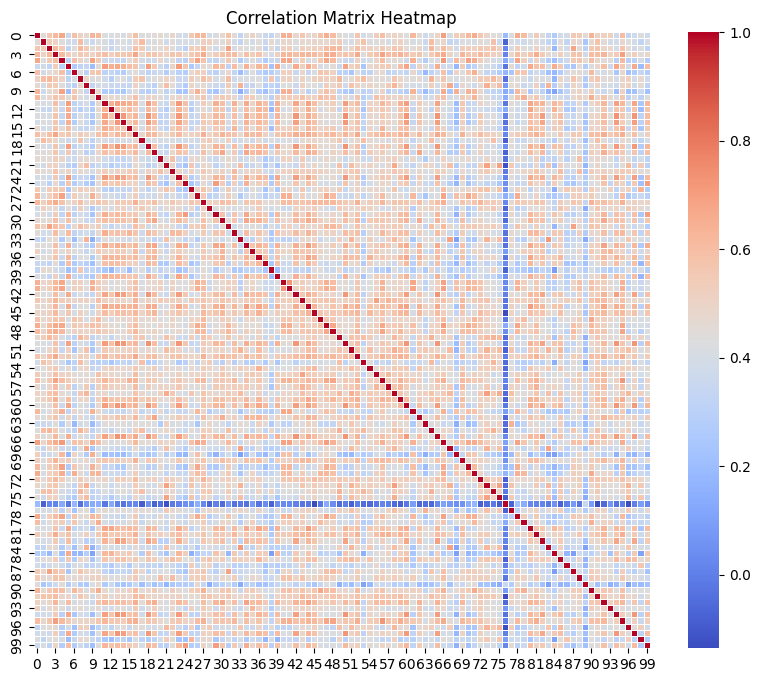

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(C1,
            cmap='coolwarm',
            linewidths=0.5,
            square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Get Denoised Covariance Matrix

After applying the denoising procedure to the correlation matrix, the corr2cov function is used to convert it back into a variance-covariance matrix.  
This allows the retrieval of the **denoised variance-covariance matrix**, which can be employed for portfolio optimization, risk estimation, or further quantitative analysis.


In [ ]:
Cov_reconstructed = corr2cov(C1, np.sqrt(np.diag(cov_training)))
Cov_reconstructed= pd.DataFrame(Cov_reconstructed)
Cov_reconstructed

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.115681,0.046747,0.053134,0.058565,0.081972,0.053723,0.113809,0.048102,0.045600,0.068408,...,0.073244,0.056109,0.053202,0.053565,0.044468,0.060867,0.022531,0.050070,0.033811,0.043720
1,0.046747,0.096602,0.046890,0.043995,0.048622,0.051140,0.067199,0.051649,0.034995,0.036441,...,0.049316,0.057998,0.043005,0.036684,0.042528,0.044309,0.026519,0.047009,0.023513,0.043594
2,0.053134,0.046890,0.077627,0.048057,0.054588,0.039329,0.070965,0.047842,0.044505,0.040456,...,0.052277,0.051550,0.041527,0.040669,0.038258,0.047350,0.024982,0.040465,0.028316,0.030253
3,0.058565,0.043995,0.048057,0.077923,0.060092,0.064645,0.075122,0.042669,0.043577,0.045115,...,0.057255,0.054362,0.053282,0.042609,0.054252,0.057420,0.025745,0.058255,0.028851,0.047112
4,0.081972,0.048622,0.054588,0.060092,0.127370,0.047167,0.119082,0.049232,0.044890,0.078533,...,0.071801,0.055799,0.048008,0.047938,0.036884,0.064090,0.020329,0.041880,0.033315,0.033925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.060867,0.044309,0.047350,0.057420,0.064090,0.070034,0.080733,0.040180,0.041858,0.048127,...,0.058873,0.055944,0.055595,0.040172,0.055685,0.086270,0.022688,0.059876,0.024543,0.052196
96,0.022531,0.026519,0.024982,0.025745,0.020329,0.032894,0.024659,0.028439,0.029673,0.013178,...,0.026089,0.030674,0.023893,0.024698,0.032253,0.022688,0.039400,0.034773,0.024585,0.025912
97,0.050070,0.047009,0.040465,0.058255,0.041880,0.113059,0.058244,0.042086,0.041799,0.027548,...,0.058236,0.060847,0.066857,0.050949,0.099954,0.059876,0.034773,0.151272,0.028135,0.080162
98,0.033811,0.023513,0.028316,0.028851,0.033315,0.020465,0.045638,0.030902,0.031085,0.027188,...,0.033584,0.028667,0.023299,0.031927,0.024559,0.024543,0.024585,0.028135,0.055246,0.021621


# Section 5: Portfolio Allocation Analysis

In this section, key portfolio statistics such as **Expected Return**, **Variance**, and **Sharpe Ratio** are computed and visualized for the following portfolios:

- Equally Weighted Portfolio  
- Global Minimum Variance Portfolio (before denoising)  
- Maximum Sharpe Ratio Portfolio (before denoising)  
- Global Minimum Variance Portfolio (after denoising)  
- Maximum Sharpe Ratio Portfolio (after denoising)  

These metrics allow for an evaluation of the effect of the denoising procedure on portfolio construction and on the trade-off between risk and return.


In [ ]:
w_minVar_training_denoised = optPortNum(Cov_reconstructed)
w_MaxSharpe_training_denoised = optPortNum(Cov_reconstructed, mu_training, 2, False)

w_minVar_denoised_statsOOS = ptf_stats(w_minVar_training_denoised, mu_test, cov_test, rf_test)
w_MaxSharpe_denoised_statsOSS = ptf_stats(w_MaxSharpe_training_denoised, mu_test, cov_test, rf_test)

stats_OOS = pd.DataFrame([w_naive_statsOOS1, w_minVar_statsOOS1, w_MaxSharpe_statsOSS1, w_minVar_denoised_statsOOS, w_MaxSharpe_denoised_statsOSS],\
                    columns = ['Exp Return', 'Var', 'SR'],
                    index = ['Naive','Min Var','Max Sharpe', 'Min Var - denoised', 'Max Sharpe - denoised'])

stats_OOS.T

,Naive,Min Var,Max Sharpe,Min Var - denoised,Max Sharpe - denoised
Exp Return,0.175598,-0.370551,-0.425884,-0.034139,0.394299
Var,0.014728,0.041071,0.172483,0.011418,0.202859
SR,1.443489,-1.830499,-1.026470,-0.323420,0.874512


<Axes: >

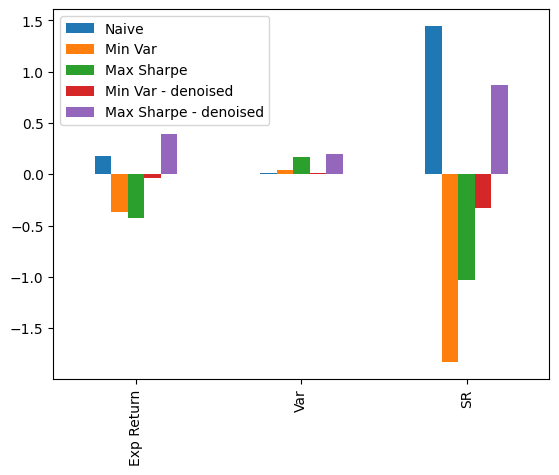

In [ ]:
(stats_OOS.T).plot(kind='bar')

# Section 6: Sensitivity Analysis

A sensitivity analysis is now performed by computing the number of noisy eigenvalues as the number of assets increases.  
Specifically, the Marchenko–Pastur procedure is applied iteratively: starting from a small subset of stocks, one column (i.e., one stock) from the original dataset is added at each iteration. At each step, the number of noisy eigenvalues detected is recorded.


In [ ]:
eig_noisy=[]
for i in range(len(tickers)):
  price= prices.copy()
  price= price.iloc[:,:i+1]
  returns = (price/price.shift(1))[1:] -1
  price_training = price['2018-1-1':'2021-6-30']
  mu_training, cov_training = getMoments(price_training)
  corr_training = cov2corr(cov_training)
  Lambda_training, U_training = getSpectralDec(corr_training)
  eigvals = np.diag(Lambda_training)

  T = price_training.shape[0]
  N = price_training.shape[1]
  q= T/N
  pts= 200

  ig= 0.3
  bnds = [(0, None)]
  sigma2 = minimize(loss, ig, args=(eigvals, q, pts), method='Nelder-Mead', bounds=bnds)
  sigma2 = sigma2.x

  emp_lamb, emp_pdf = empirical_lambda(eigvals, pts=200)
  pdf_mp, a, b = MarPasPDF(sigma2, q, emp_lamb)

  n_badeig = np.sum( (np.diag(Lambda_training) <= b))

  eig_noisy.append(n_badeig)

eig_noisy

<ipython-input-3-739451292>:16: RuntimeWarning: invalid value encountered in scalar divide
  pdf_hat[i] = ((np.sum( lamb<= lamb_int[i]+epsilon)/len(lamb)) - (np.sum( lamb<= lamb_int[i]-epsilon)/len(lamb)) )/(2*epsilon)


[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(2),
 np.int64(3),
 np.int64(5),
 np.int64(5),
 np.int64(3),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(6),
 np.int64(9),
 np.int64(7),
 np.int64(8),
 np.int64(10),
 np.int64(14),
 np.int64(11),
 np.int64(11),
 np.int64(18),
 np.int64(19),
 np.int64(16),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(24),
 np.int64(20),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(32),
 np.int64(27),
 np.int64(29),
 np.int64(31),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(37),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(43),
 np.int64(29),
 np.int64(45),
 np.int64(33),
 np.int64(35),
 np.int64(36),
 np.int64(35),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(46),
 np.int64(48),
 np.int64(49

This plot illustrates how the number of noisy (bad) eigenvalues evolves as the number of assets \( N \) increases.  
An increasing trend is observed, as expected: with higher dimensionality of the correlation matrix, more eigenvalues fall within the noise band. This emphasizes the importance of applying denoising techniques in high-dimensional settings.


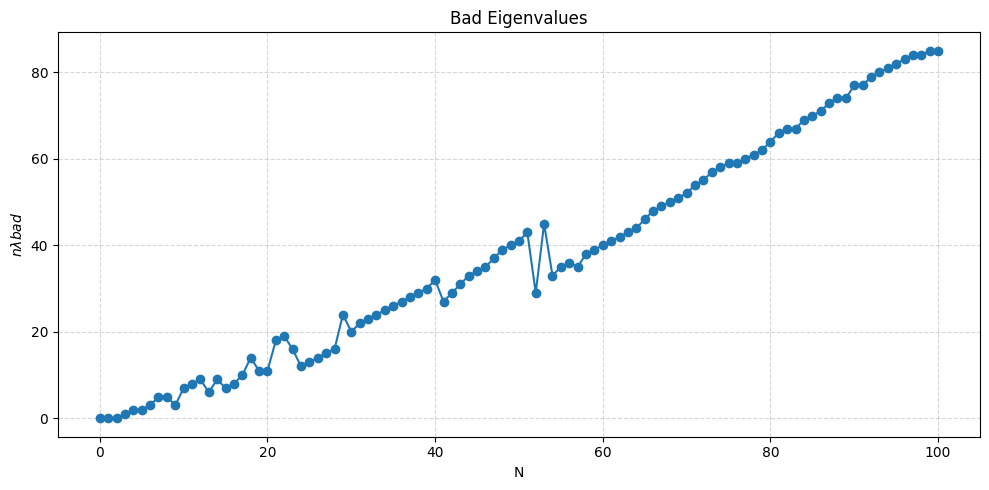

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eig_noisy, '-o')
ax.set_xlabel('N')
ax.set_ylabel(r'$n \lambda bad$')
ax.set_title('Bad Eigenvalues')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()